#Demonstration: Detecting Fraudulent Credit Card Transactions using Advanced Clustering

##Scenario
- A data analyst at a fintech company is tasked with identifying potentially fraudulent credit card transactions. Since fraud patterns are not explicitly labeled in real-time systems, the analyst leverages unsupervised clustering techniques to uncover hidden anomalies within the transaction data.










##Step 1: Import Required Libraries
- We're loading necessary libraries for data manipulation, clustering, evaluation, and plotting.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, MiniBatchKMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

##Step 2: Load and Inspect the Dataset
We load the Kaggle credit card dataset and inspect its structure.

In [2]:
df = pd.read_csv("creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


##Step 3: Preprocess Dataset
Remove 'Time' column and scale the 'Amount' for better clustering.

In [3]:
df.drop("Time", axis=1, inplace=True)

scaler = StandardScaler()
df["Amount"] = scaler.fit_transform(df[["Amount"]])

# Separate features and target
X = df.drop("Class", axis=1)
y = df["Class"]

##Step 4: Sample a Subset (for Performance)
Working on 10,000 samples to speed up clustering.

In [4]:
X_sample = X.sample(n=10000, random_state=42)
y_sample = y.loc[X_sample.index]

##Step 5: Apply KMeans with smart initialization
Perform clustering with k-means++ strategy for better results.

In [5]:
kmeans = KMeans(n_clusters=2, init="k-means++", random_state=42)
kmeans_labels = kmeans.fit_predict(X_sample)

##Step 6: Evaluate KMeans using Silhouette Score
Score tells us how well clusters are separated.

In [6]:
score = silhouette_score(X_sample, kmeans_labels)
print(f"KMeans Silhouette Score: {score:.3f}")

KMeans Silhouette Score: 0.108


##Step 7: Apply MiniBatchKMeans for faster training
Useful for large-scale real-time clustering.

In [7]:
mini_kmeans = MiniBatchKMeans(n_clusters=2, random_state=42)
mini_labels = mini_kmeans.fit_predict(X_sample)

mini_score = silhouette_score(X_sample, mini_labels)
print(f"MiniBatchKMeans Silhouette Score: {mini_score:.3f}")

MiniBatchKMeans Silhouette Score: 0.108


##Step 8: Standardize all features
DBSCAN is sensitive to feature scale, so we scale everything.

In [8]:
X_scaled = StandardScaler().fit_transform(X_sample)

##Step 9: Apply DBSCAN
DBSCAN identifies dense clusters and flags low-density points as outliers.

In [9]:
dbscan = DBSCAN(eps=2.0, min_samples=5)
db_labels = dbscan.fit_predict(X_scaled)

n_clusters = len(set(db_labels)) - (1 if -1 in db_labels else 0)
n_noise = list(db_labels).count(-1)

print(f"DBSCAN clusters: {n_clusters}, Noise points: {n_noise}")

DBSCAN clusters: 97, Noise points: 4947


##Step 10: Dimensionality Reduction for visualization
Using PCA to reduce to 2D space for plotting clusters.

In [10]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

##Plot Clusters (KMeans vs DBSCAN)
Visual comparison of KMeans and DBSCAN cluster shapes.

<ipython-input-11-66027f68fa2a>:11: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


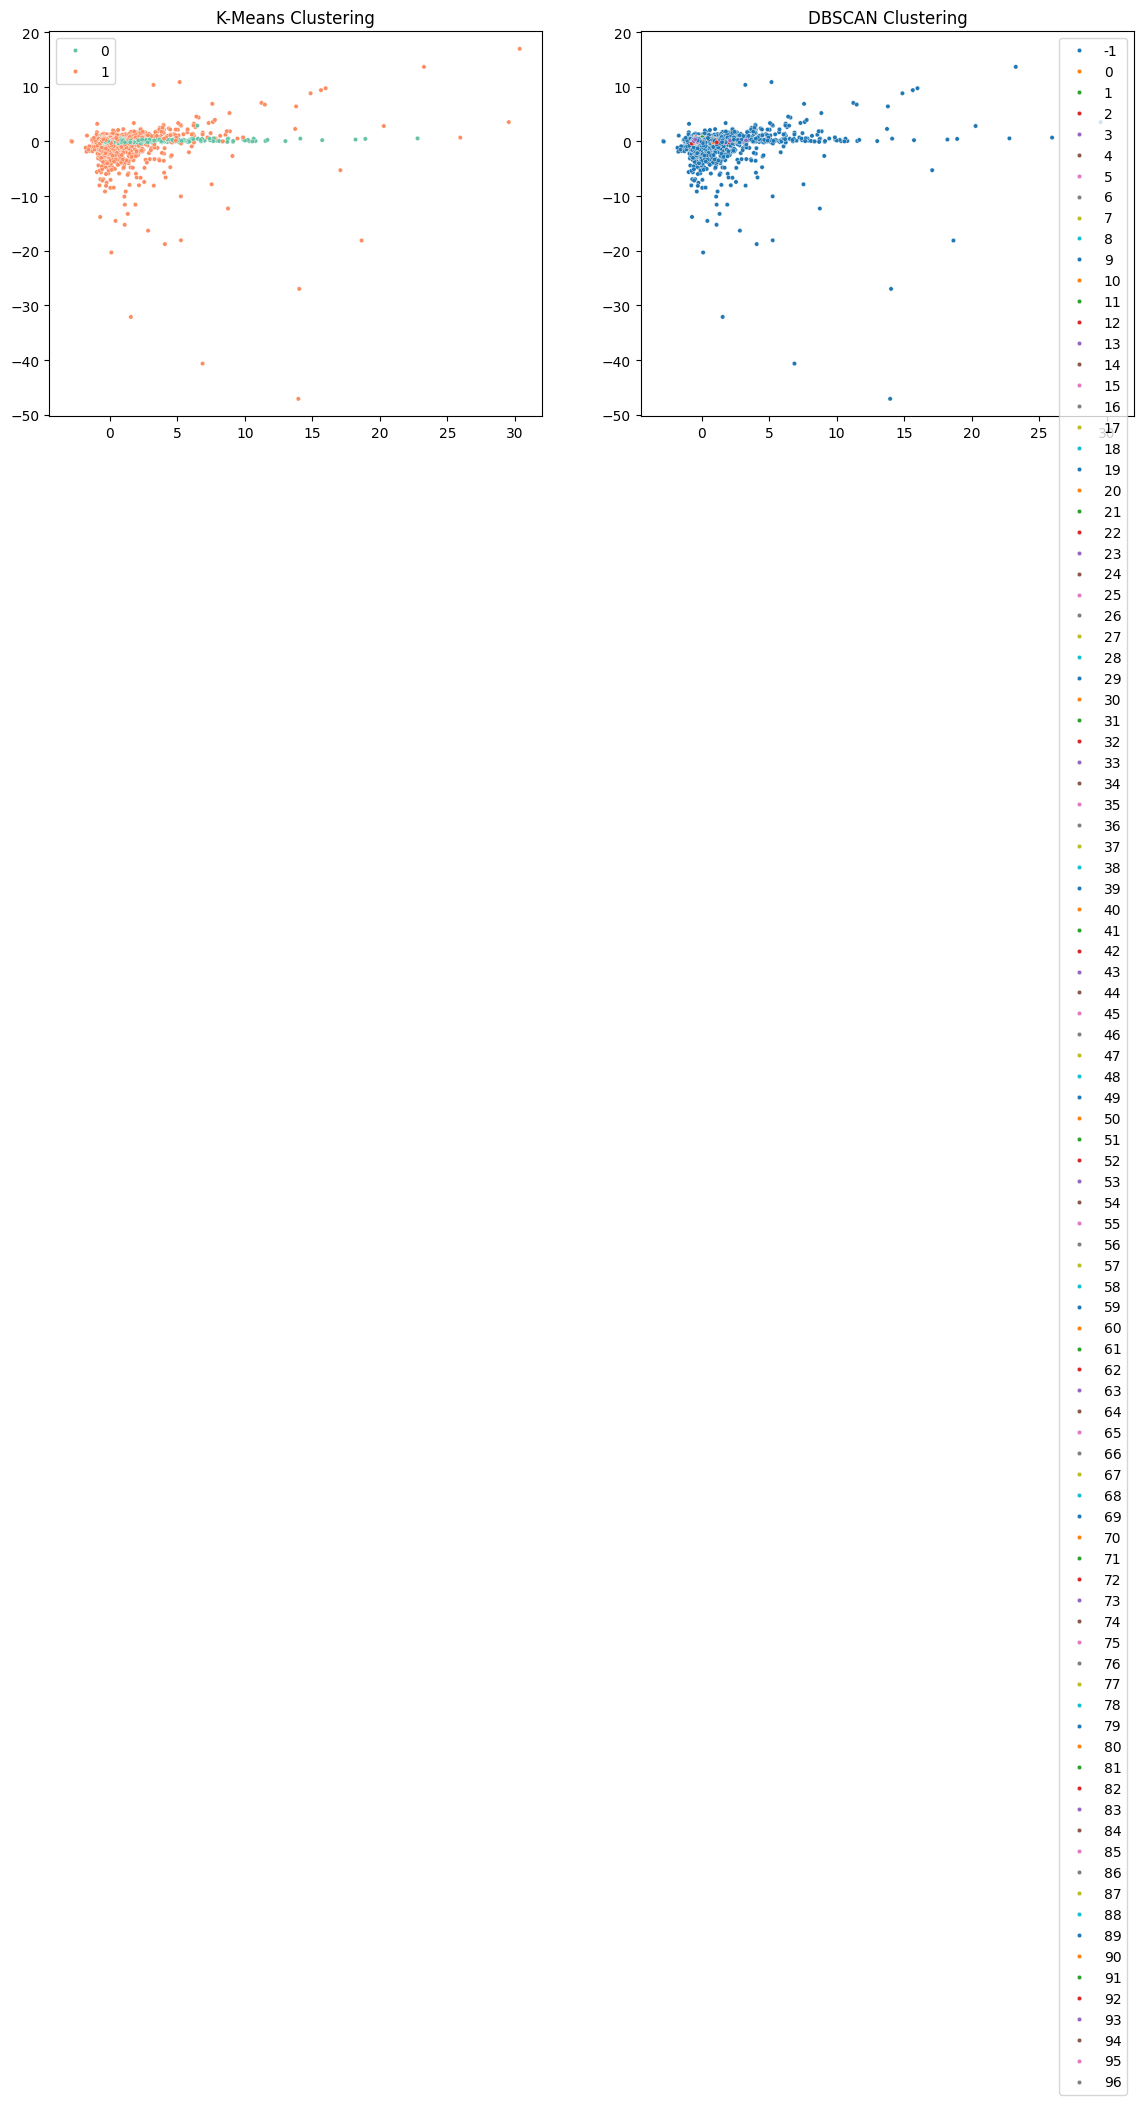

In [11]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=kmeans_labels, palette="Set2", s=10)
plt.title("K-Means Clustering")

plt.subplot(1, 2, 2)
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=db_labels, palette="tab10", s=10)
plt.title("DBSCAN Clustering")

plt.tight_layout()
plt.show()